https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather?select=energy_dataset.csv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
from skorch import NeuralNet, NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [3]:
energy = pd.read_csv("energy_dataset.csv")
energy.info()

FileNotFoundError: [Errno 2] No such file or directory: 'energy_dataset.csv'

In [ ]:
energy = energy[["time", "total load actual"]]
energy

,time,total load actual
0,2015-01-01 00:00:00+01:00,25385.0
1,2015-01-01 01:00:00+01:00,24382.0
2,2015-01-01 02:00:00+01:00,22734.0
3,2015-01-01 03:00:00+01:00,21286.0
4,2015-01-01 04:00:00+01:00,20264.0
...,...,...
35059,2018-12-31 19:00:00+01:00,30653.0
35060,2018-12-31 20:00:00+01:00,29735.0
35061,2018-12-31 21:00:00+01:00,28071.0
35062,2018-12-31 22:00:00+01:00,25801.0


In [ ]:
weather = pd.read_csv("weather_features.csv")
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [ ]:
# delete unrelated attributes
weather_clean = weather.copy()
weather_clean = weather_clean.drop(["clouds_all", "weather_id", "wind_deg", "weather_main", "weather_description", "weather_icon"], axis=1)
weather_clean

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_3h
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,0.0,0.0,0.0
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,0.0,0.0,0.0
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,0.0,0.0,0.0
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,0.0,0.0,0.0
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,287.760,287.150,288.150,1028,54,3,0.0,0.0,0.0
178392,2018-12-31 20:00:00+01:00,Seville,285.760,285.150,286.150,1029,62,3,0.0,0.0,0.0
178393,2018-12-31 21:00:00+01:00,Seville,285.150,285.150,285.150,1028,58,4,0.0,0.0,0.0
178394,2018-12-31 22:00:00+01:00,Seville,284.150,284.150,284.150,1029,57,4,0.0,0.0,0.0


In [ ]:
# since there are weather measurements from 4 different cities, take the average of the 4 cities 
weather_clean = weather_clean.groupby(['dt_iso']).mean()
weather_clean


,temp,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_3h
dt_iso,,,,,,,,,
2015-01-01 00:00:00+01:00,272.491463,272.491463,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0
2015-01-01 01:00:00+01:00,272.512700,272.512700,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0
2015-01-01 02:00:00+01:00,272.099137,272.099137,272.099137,1016.8,82.0,2.4,0.0,0.0,0.0
2015-01-01 03:00:00+01:00,272.089469,272.089469,272.089469,1016.6,82.0,2.4,0.0,0.0,0.0
2015-01-01 04:00:00+01:00,272.145900,272.145900,272.145900,1016.6,82.0,2.4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,284.470000,283.350000,285.550000,1029.2,73.6,1.4,0.0,0.0,0.0
2018-12-31 20:00:00+01:00,282.294000,280.950000,283.350000,1030.0,68.0,1.8,0.0,0.0,0.0
2018-12-31 21:00:00+01:00,280.850000,280.350000,281.350000,1029.8,71.4,2.6,0.0,0.0,0.0


In [ ]:
# combine the two dataframes
energy_weather = energy.merge(weather_clean, left_on='time', right_on='dt_iso', suffixes=None)
energy_weather

/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/pandas/core/frame.py:8195: FutureWarning: Passing 'suffixes' as a <class 'NoneType'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  return merge(


,time,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_3h
0,2015-01-01 00:00:00+01:00,25385.0,272.491463,272.491463,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0
1,2015-01-01 01:00:00+01:00,24382.0,272.512700,272.512700,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0
2,2015-01-01 02:00:00+01:00,22734.0,272.099137,272.099137,272.099137,1016.8,82.0,2.4,0.0,0.0,0.0
3,2015-01-01 03:00:00+01:00,21286.0,272.089469,272.089469,272.089469,1016.6,82.0,2.4,0.0,0.0,0.0
4,2015-01-01 04:00:00+01:00,20264.0,272.145900,272.145900,272.145900,1016.6,82.0,2.4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,30653.0,284.470000,283.350000,285.550000,1029.2,73.6,1.4,0.0,0.0,0.0
35060,2018-12-31 20:00:00+01:00,29735.0,282.294000,280.950000,283.350000,1030.0,68.0,1.8,0.0,0.0,0.0
35061,2018-12-31 21:00:00+01:00,28071.0,280.850000,280.350000,281.350000,1029.8,71.4,2.6,0.0,0.0,0.0
35062,2018-12-31 22:00:00+01:00,25801.0,279.718000,278.750000,280.750000,1030.2,70.0,2.8,0.0,0.0,0.0


In [ ]:
# check for missing values
energy_weather.isna().sum()

time                  0
total load actual    36
temp                  0
temp_min              0
temp_max              0
pressure              0
humidity              0
wind_speed            0
rain_1h               0
rain_3h               0
snow_3h               0
dtype: int64

In [ ]:
# delete row with missing value
energy_weather = energy_weather.dropna()
energy_weather

,time,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_3h
0,2015-01-01 00:00:00+01:00,25385.0,272.491463,272.491463,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0
1,2015-01-01 01:00:00+01:00,24382.0,272.512700,272.512700,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0
2,2015-01-01 02:00:00+01:00,22734.0,272.099137,272.099137,272.099137,1016.8,82.0,2.4,0.0,0.0,0.0
3,2015-01-01 03:00:00+01:00,21286.0,272.089469,272.089469,272.089469,1016.6,82.0,2.4,0.0,0.0,0.0
4,2015-01-01 04:00:00+01:00,20264.0,272.145900,272.145900,272.145900,1016.6,82.0,2.4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,30653.0,284.470000,283.350000,285.550000,1029.2,73.6,1.4,0.0,0.0,0.0
35060,2018-12-31 20:00:00+01:00,29735.0,282.294000,280.950000,283.350000,1030.0,68.0,1.8,0.0,0.0,0.0
35061,2018-12-31 21:00:00+01:00,28071.0,280.850000,280.350000,281.350000,1029.8,71.4,2.6,0.0,0.0,0.0
35062,2018-12-31 22:00:00+01:00,25801.0,279.718000,278.750000,280.750000,1030.2,70.0,2.8,0.0,0.0,0.0


In [ ]:
# Change time column to datetime format
energy_weather['time'] = pd.to_datetime(energy_weather['time'], errors='coerce', utc=True)

# Change the time format
energy_weather['datetime'] = energy_weather['time'].dt.strftime('%Y-%m-%d %H:00:00')

energy_weather


<ipython-input-10-9054516f4a7f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_weather['time'] = pd.to_datetime(energy_weather['time'], errors='coerce', utc=True)
<ipython-input-10-9054516f4a7f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_weather['datetime'] = energy_weather['time'].dt.strftime('%Y-%m-%d %H:00:00')


,time,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_3h,datetime
0,2014-12-31 23:00:00+00:00,25385.0,272.491463,272.491463,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0,2014-12-31 23:00:00
1,2015-01-01 00:00:00+00:00,24382.0,272.512700,272.512700,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0,2015-01-01 00:00:00
2,2015-01-01 01:00:00+00:00,22734.0,272.099137,272.099137,272.099137,1016.8,82.0,2.4,0.0,0.0,0.0,2015-01-01 01:00:00
3,2015-01-01 02:00:00+00:00,21286.0,272.089469,272.089469,272.089469,1016.6,82.0,2.4,0.0,0.0,0.0,2015-01-01 02:00:00
4,2015-01-01 03:00:00+00:00,20264.0,272.145900,272.145900,272.145900,1016.6,82.0,2.4,0.0,0.0,0.0,2015-01-01 03:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,30653.0,284.470000,283.350000,285.550000,1029.2,73.6,1.4,0.0,0.0,0.0,2018-12-31 18:00:00
35060,2018-12-31 19:00:00+00:00,29735.0,282.294000,280.950000,283.350000,1030.0,68.0,1.8,0.0,0.0,0.0,2018-12-31 19:00:00
35061,2018-12-31 20:00:00+00:00,28071.0,280.850000,280.350000,281.350000,1029.8,71.4,2.6,0.0,0.0,0.0,2018-12-31 20:00:00
35062,2018-12-31 21:00:00+00:00,25801.0,279.718000,278.750000,280.750000,1030.2,70.0,2.8,0.0,0.0,0.0,2018-12-31 21:00:00


In [ ]:
# change datetime to datetime object
energy_weather['datetime'] = pd.to_datetime(energy_weather['datetime'])

# delete time column
energy_weather = energy_weather.drop(['time'], axis=1)

energy_weather

<ipython-input-11-6dc69729cb3f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_weather['datetime'] = pd.to_datetime(energy_weather['datetime'])


,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_3h,datetime
0,25385.0,272.491463,272.491463,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0,2014-12-31 23:00:00
1,24382.0,272.512700,272.512700,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0,2015-01-01 00:00:00
2,22734.0,272.099137,272.099137,272.099137,1016.8,82.0,2.4,0.0,0.0,0.0,2015-01-01 01:00:00
3,21286.0,272.089469,272.089469,272.089469,1016.6,82.0,2.4,0.0,0.0,0.0,2015-01-01 02:00:00
4,20264.0,272.145900,272.145900,272.145900,1016.6,82.0,2.4,0.0,0.0,0.0,2015-01-01 03:00:00
...,...,...,...,...,...,...,...,...,...,...,...
35059,30653.0,284.470000,283.350000,285.550000,1029.2,73.6,1.4,0.0,0.0,0.0,2018-12-31 18:00:00
35060,29735.0,282.294000,280.950000,283.350000,1030.0,68.0,1.8,0.0,0.0,0.0,2018-12-31 19:00:00
35061,28071.0,280.850000,280.350000,281.350000,1029.8,71.4,2.6,0.0,0.0,0.0,2018-12-31 20:00:00
35062,25801.0,279.718000,278.750000,280.750000,1030.2,70.0,2.8,0.0,0.0,0.0,2018-12-31 21:00:00


In [ ]:
# set datetime as the index
energy_weather = energy_weather.set_index('datetime')

In [ ]:
energy_weather.describe()

,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_3h
count,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000
mean,28696.939905,289.684788,288.400616,291.152796,1070.267210,68.218149,2.467450,0.073094,0.000386,0.004810
std,4574.987950,7.261355,7.122590,7.507555,2693.648949,14.893776,1.357864,0.202491,0.003361,0.101129
min,18041.000000,271.941862,270.550000,271.941862,812.400000,22.600000,0.000000,0.000000,0.000000,0.000000
25%,24807.750000,284.064000,282.950000,285.350000,1012.800000,56.800000,1.400000,0.000000,0.000000,0.000000
50%,28901.000000,289.030300,287.750000,290.550000,1017.000000,69.800000,2.200000,0.000000,0.000000,0.000000
75%,32192.000000,295.094500,293.618000,296.750000,1021.000000,80.200000,3.200000,0.060000,0.000000,0.000000
max,41015.000000,309.266000,308.550000,313.548000,202469.000000,100.000000,29.800000,4.150000,0.463000,4.300000


array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>],
      dtype=object)

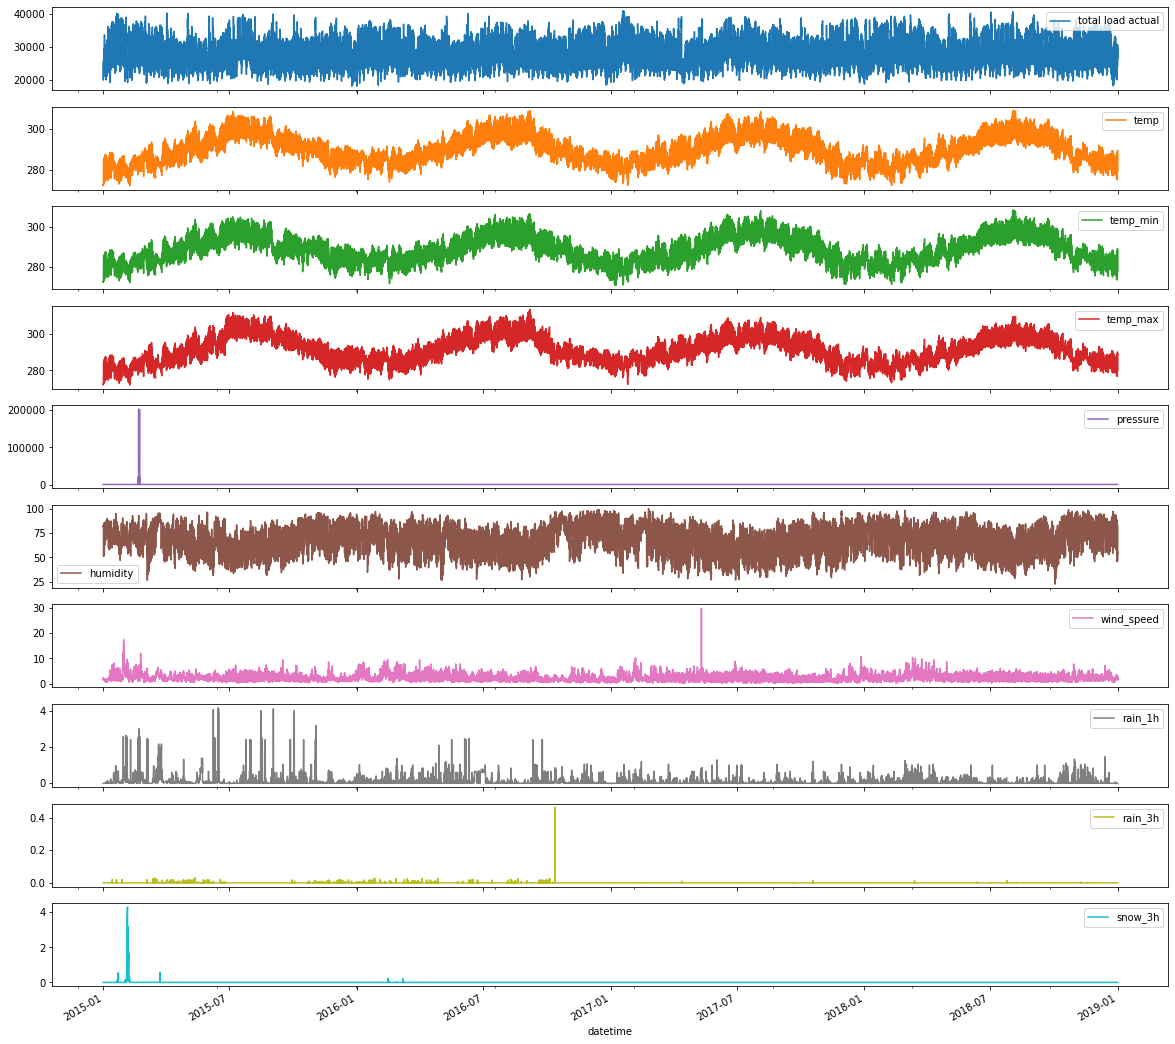

In [ ]:
# plot for each column
energy_weather.plot(figsize=(20, 20), subplots=True)

In [ ]:
# define a function to replace outliers (value higher or lower than 2 s.d. from the mean) with the median
def replace_outlier(column):
    sd = column.std()
    median = column.median()
    mean = column.mean()
    condition = (column > mean + 2*sd) | (column < mean + 2*sd)
    column = column.mask(column > mean + 2.5*sd, median)
    return column

In [ ]:
# apply function to 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'rain_3h' columns
energy_weather_no_outliers = energy_weather.copy()
energy_weather_no_outliers[['pressure', 'temp', 'temp_min', 'temp_max', 'humidity', 'wind_speed', 'rain_1h', 'rain_3h']]= energy_weather_no_outliers[['pressure', 'temp', 'temp_min', 'temp_max', 'humidity', 'wind_speed', 'rain_1h', 'rain_3h']].apply(replace_outlier)

# change the unit for temperature from K to C
energy_weather_no_outliers['temp'] = energy_weather_no_outliers['temp'] - 273
energy_weather_no_outliers['temp_min'] = energy_weather_no_outliers['temp_min'] - 273
energy_weather_no_outliers['temp_max'] = energy_weather_no_outliers['temp_max'] - 273
energy_weather_no_outliers.describe()

,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_3h
count,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000
mean,28696.939905,16.661424,15.376100,18.125981,1016.391751,68.218149,2.353799,0.042302,0.000088,0.004810
std,4574.987950,7.232004,7.091091,7.473056,18.705194,14.893776,1.141852,0.084722,0.000640,0.101129
min,18041.000000,-1.058138,-2.450000,-1.058138,812.400000,22.600000,0.000000,0.000000,0.000000,0.000000
25%,24807.750000,11.064000,9.950000,12.350000,1012.800000,56.800000,1.400000,0.000000,0.000000,0.000000
50%,28901.000000,16.029950,14.750000,17.550000,1017.000000,69.800000,2.200000,0.000000,0.000000,0.000000
75%,32192.000000,22.054500,20.552000,23.750000,1021.000000,80.200000,3.000000,0.060000,0.000000,0.000000
max,41015.000000,34.824000,33.188000,36.908000,2832.000000,100.000000,5.857143,0.566667,0.008600,4.300000


In [ ]:
# replace pressure higher than world record of 1084.8 with median
energy_weather_no_outliers['pressure'] = energy_weather_no_outliers['pressure'].mask(energy_weather_no_outliers['pressure'] > 1084.4, energy_weather_no_outliers['pressure'].median())

# replace pressure lower than world record of 870 with median
energy_weather_no_outliers['pressure'] = energy_weather_no_outliers['pressure'].mask(energy_weather_no_outliers['pressure'] < 870, energy_weather_no_outliers['pressure'].median())

energy_weather_no_outliers.describe()

,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_3h
count,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000
mean,28696.939905,16.661424,15.376100,18.125981,1016.248945,68.218149,2.353799,0.042302,0.000088,0.004810
std,4574.987950,7.232004,7.091091,7.473056,8.284683,14.893776,1.141852,0.084722,0.000640,0.101129
min,18041.000000,-1.058138,-2.450000,-1.058138,933.200000,22.600000,0.000000,0.000000,0.000000,0.000000
25%,24807.750000,11.064000,9.950000,12.350000,1012.800000,56.800000,1.400000,0.000000,0.000000,0.000000
50%,28901.000000,16.029950,14.750000,17.550000,1017.000000,69.800000,2.200000,0.000000,0.000000,0.000000
75%,32192.000000,22.054500,20.552000,23.750000,1021.000000,80.200000,3.000000,0.060000,0.000000,0.000000
max,41015.000000,34.824000,33.188000,36.908000,1039.800000,100.000000,5.857143,0.566667,0.008600,4.300000


array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>],
      dtype=object)

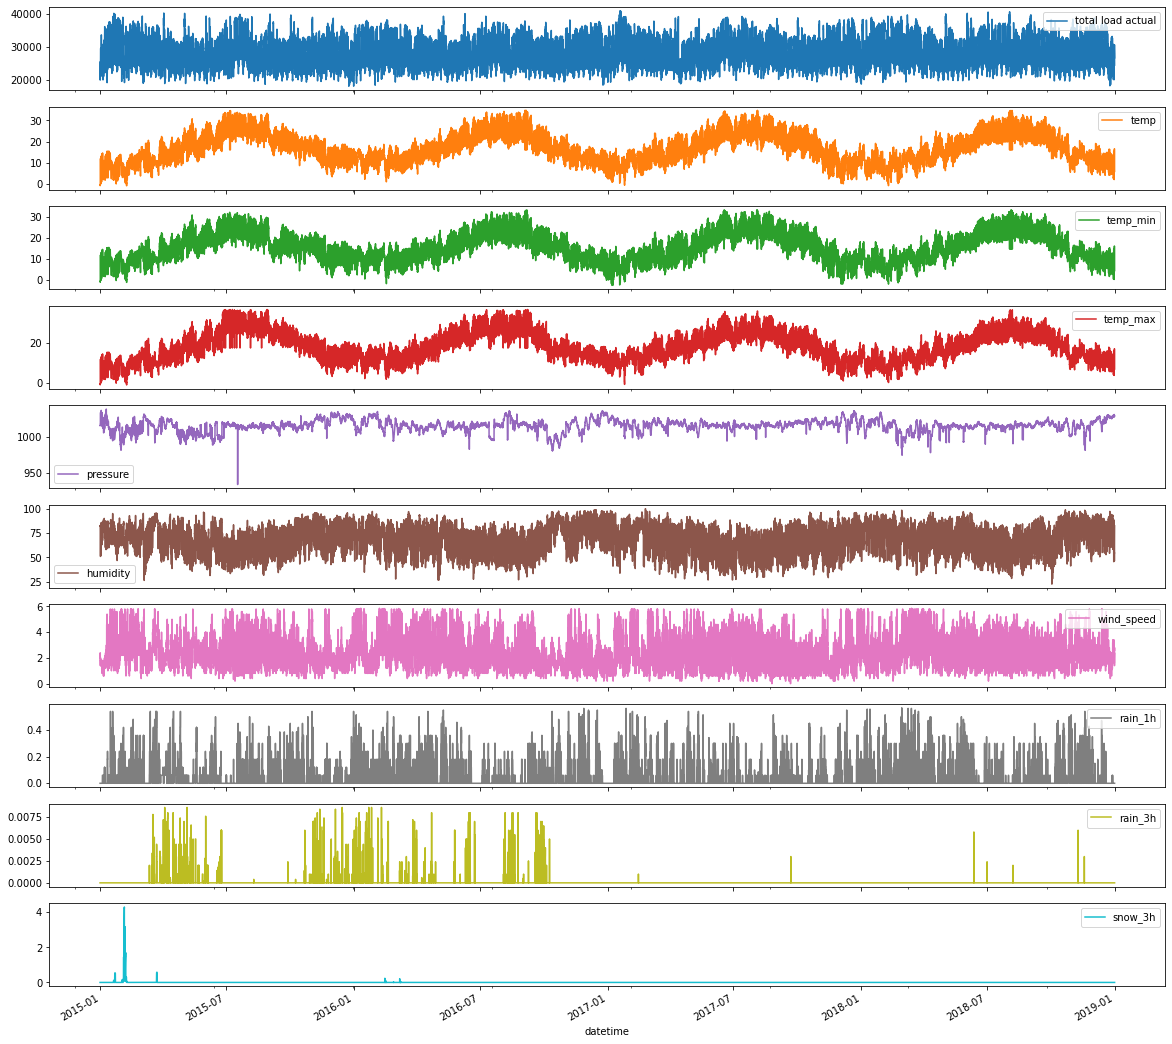

In [ ]:
# plot for each column
energy_weather_no_outliers.plot(figsize=(20, 20), subplots=True)


## Remove outliers in the energy consumption column

In [ ]:
# code from https://medium.com/swlh/5-tips-for-working-with-time-series-in-python-d889109e676d

def basic_filter(data, mode='rolling', window=168, threshold=2):
    """Basic Filter.
    
    Mark as outliers the points that are out of the interval:
    (mean - threshold * std, mean + threshold * std ).
    
    Parameters
    ----------
    data : pandas.Series
        The time series to filter.
    mode : str, optional, default: 'rolling'
        Whether to filter in rolling or expanding basis.
    window : int, optional, default: 262
        The number of periods to compute the mean and standard
        deviation.
    threshold : int, optional, default: 3
        The number of standard deviations above the mean.
        
    Returns
    -------
    series : pandas.DataFrame
        Original series and marked outliers.
    """
    msg = f"Type must be of pandas.Series but {type(data)} was passed."
    assert isinstance(data, pd.Series), msg
    
    series = data.copy()
    
    # rolling/expanding objects
    pd_object = getattr(series, mode)(window=window)
    mean = pd_object.mean()
    std = pd_object.std()
    
    upper_bound = mean + threshold * std
    lower_bound = mean - threshold * std
    
    outliers = ~series.between(lower_bound, upper_bound)
    # fill false positives with 0
    outliers.iloc[:window] = np.zeros(shape=window)
    
    series = series.to_frame()
    series['outliers'] = np.array(outliers.astype('int').values)
    series.columns = ['Close', 'Outliers']
    
    return series

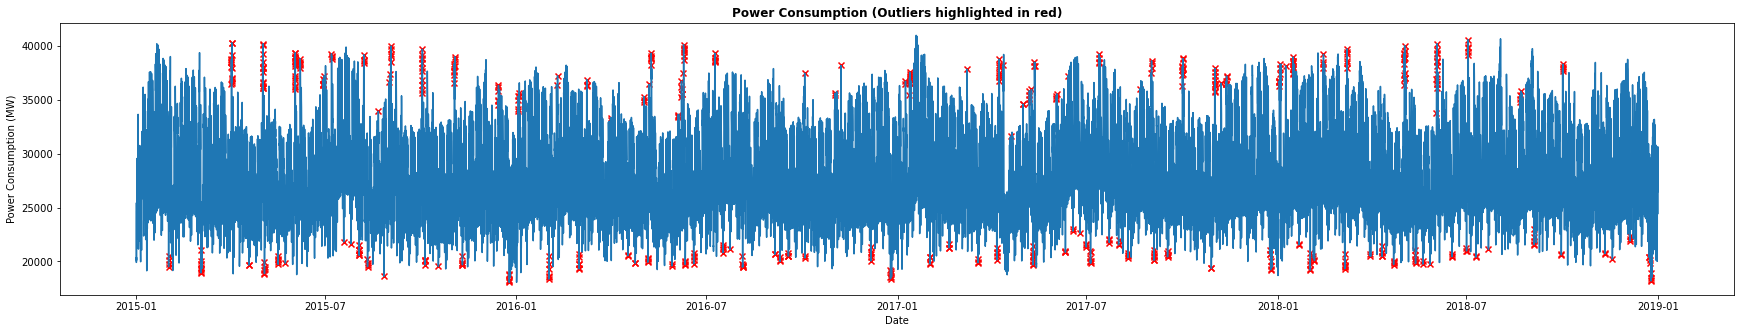

In [ ]:
# check if the energy value is an outlier
energy_outliers = basic_filter(energy_weather_no_outliers['total load actual'])

# add the outlier column to the energy_weather_no_outliers dataframe
energy_weather_no_outliers['outlier'] = energy_outliers['Outliers']

# show the outlier in plot
plt.figure(figsize=(30, 5))
plt.plot(energy_weather_no_outliers["total load actual"])

outliers = energy_weather_no_outliers["outlier"]
plt.scatter(energy_weather_no_outliers.loc[outliers == 1].index, energy_weather_no_outliers.loc[outliers == 1]["total load actual"], c = 'red', marker="x")
plt.xlabel("Date")
plt.ylabel("Power Consumption (MW)")
plt.title("Power Consumption (Outliers highlighted in red)", fontweight="bold")
plt.show()


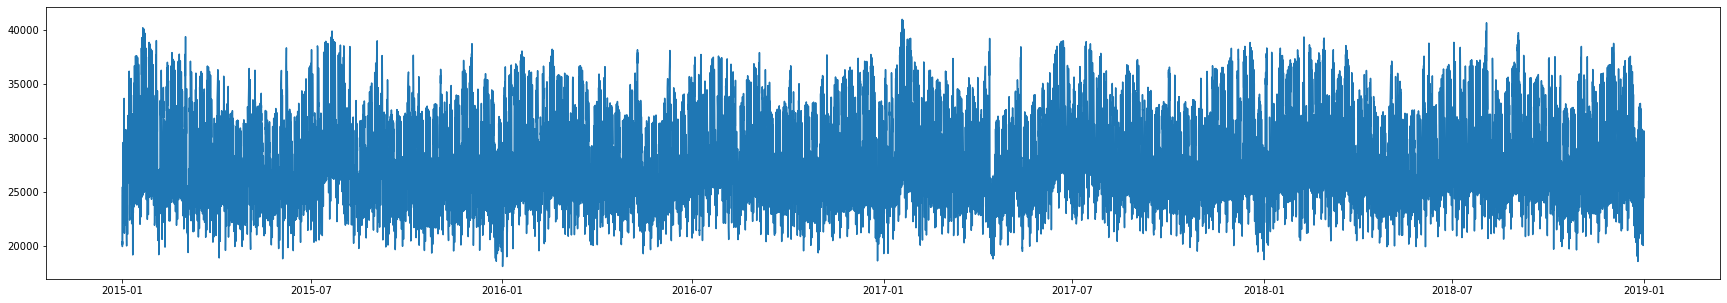

In [ ]:
# only select non-outlier data
energy_weather_no_outliers = energy_weather_no_outliers.loc[energy_weather_no_outliers['outlier'] == 0]

# show data after removing outlier
plt.figure(figsize=(30, 5))
plt.plot(energy_weather_no_outliers["total load actual"])

In [ ]:
energy_weather_no_outliers

,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_3h,outlier
datetime,,,,,,,,,,,
2014-12-31 23:00:00,25385.0,-0.508537,-0.508537,-0.508537,1016.4,82.4,2.0,0.0,0.0,0.0,0
2015-01-01 00:00:00,24382.0,-0.487300,-0.487300,-0.487300,1016.2,82.4,2.0,0.0,0.0,0.0,0
2015-01-01 01:00:00,22734.0,-0.900863,-0.900863,-0.900863,1016.8,82.0,2.4,0.0,0.0,0.0,0
2015-01-01 02:00:00,21286.0,-0.910531,-0.910531,-0.910531,1016.6,82.0,2.4,0.0,0.0,0.0,0
2015-01-01 03:00:00,20264.0,-0.854100,-0.854100,-0.854100,1016.6,82.0,2.4,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00,30653.0,11.470000,10.350000,12.550000,1029.2,73.6,1.4,0.0,0.0,0.0,0
2018-12-31 19:00:00,29735.0,9.294000,7.950000,10.350000,1030.0,68.0,1.8,0.0,0.0,0.0,0
2018-12-31 20:00:00,28071.0,7.850000,7.350000,8.350000,1029.8,71.4,2.6,0.0,0.0,0.0,0


### Remove noise using Fourier Transform

In [ ]:
def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    
    Denoises data using the fast fourier transform.
    
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)
        
    Returns
    -------
    clean_data : numpy.array
        The denoised data.
        
    References
    ----------
    .. [1] Steve Brunton - Denoising Data with FFT[Python]
       https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
    
    """
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

In [ ]:
denoised = fft_denoiser(energy_weather_no_outliers['total load actual'], 800000000)
denoised
energy_weather_no_outliers['denoised_data'] = denoised
energy_weather_no_outliers

NameError: name 'fft_denoiser' is not defined

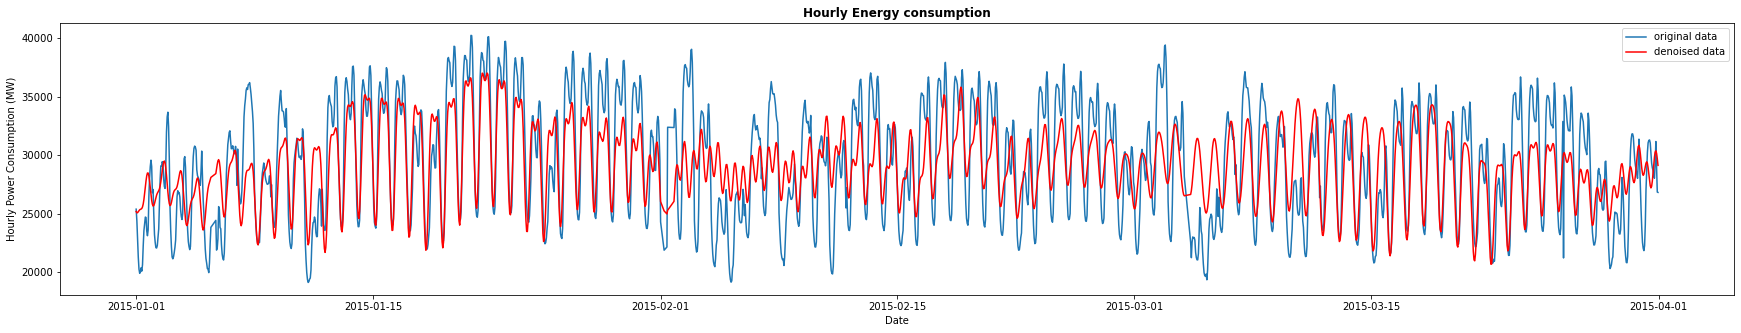

In [ ]:
# plt.plot(denoised_data_05)
plt.figure(figsize=(30, 5))
plt.plot(energy_weather_no_outliers.loc['2015-01-01':'2015-03-31'].index, energy_weather_no_outliers['total load actual'][:2130], label='original data')
plt.plot(energy_weather_no_outliers.loc['2015-01-01':'2015-03-31'].index, energy_weather_no_outliers['denoised_data'][:2130], color='r', label = "denoised data")


plt.xlabel("Date")
plt.ylabel("Hourly Power Consumption (MW)")

plt.title("Hourly Energy consumption", fontweight="bold")
plt.legend()
plt.show()

In [ ]:
energy_weather_no_outliers

,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_3h,outlier,denoised_data
datetime,,,,,,,,,,,,
2014-12-31 23:00:00,25385.0,-0.508537,-0.508537,-0.508537,1016.4,82.4,2.0,0.0,0.0,0.0,0,25187.771198
2015-01-01 00:00:00,24382.0,-0.487300,-0.487300,-0.487300,1016.2,82.4,2.0,0.0,0.0,0.0,0,25075.976424
2015-01-01 01:00:00,22734.0,-0.900863,-0.900863,-0.900863,1016.8,82.0,2.4,0.0,0.0,0.0,0,25086.002532
2015-01-01 02:00:00,21286.0,-0.910531,-0.910531,-0.910531,1016.6,82.0,2.4,0.0,0.0,0.0,0,25165.377386
2015-01-01 03:00:00,20264.0,-0.854100,-0.854100,-0.854100,1016.6,82.0,2.4,0.0,0.0,0.0,0,25260.305745
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00,30653.0,11.470000,10.350000,12.550000,1029.2,73.6,1.4,0.0,0.0,0.0,0,27556.574344
2018-12-31 19:00:00,29735.0,9.294000,7.950000,10.350000,1030.0,68.0,1.8,0.0,0.0,0.0,0,27008.920549
2018-12-31 20:00:00,28071.0,7.850000,7.350000,8.350000,1029.8,71.4,2.6,0.0,0.0,0.0,0,26419.225016


In [ ]:
# delete the columns 'totaal load actual' and 'outlier'
energy_weather_no_outliers = energy_weather_no_outliers.drop(['total load actual', 'outlier'], axis=1)
energy_weather_no_outliers.head()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_3h,denoised_data
datetime,,,,,,,,,,
2014-12-31 23:00:00,-0.508537,-0.508537,-0.508537,1016.4,82.4,2.0,0.0,0.0,0.0,25187.771198
2015-01-01 00:00:00,-0.487300,-0.487300,-0.487300,1016.2,82.4,2.0,0.0,0.0,0.0,25075.976424
2015-01-01 01:00:00,-0.900863,-0.900863,-0.900863,1016.8,82.0,2.4,0.0,0.0,0.0,25086.002532
2015-01-01 02:00:00,-0.910531,-0.910531,-0.910531,1016.6,82.0,2.4,0.0,0.0,0.0,25165.377386
2015-01-01 03:00:00,-0.854100,-0.854100,-0.854100,1016.6,82.0,2.4,0.0,0.0,0.0,25260.305745


## Split the dataset to training, validation and test set

In [ ]:
# split the data into 70% training, 10% validation and 20% test set
train_idx = int(len(energy_weather_no_outliers)*0.7)
validation_idx = int(len(energy_weather_no_outliers)*0.8)
# print(train_index)
# print(validation_index)

from sklearn.model_selection import train_test_split
train_data = energy_weather_no_outliers.iloc[:train_idx]
validation_data = energy_weather_no_outliers.iloc[train_idx:validation_idx]
test_data = energy_weather_no_outliers.iloc[validation_idx:]

print("training set sample size is", len(train_data))
print("validation set sample size is", len(validation_data))
print("test set sample size is", len(test_data))

print("total sample size is", len(train_data)+ len(validation_data) +len(test_data))

training set sample size is 24142
validation set sample size is 3449
test set sample size is 6898
total sample size is 34489


In [ ]:
# standardize data
scaler = MinMaxScaler(feature_range = (0, 1))
scaler = scaler.fit(train_data)


In [ ]:
train_data = pd.DataFrame(scaler.transform(train_data), index=train_data.index, columns=train_data.columns)
train_data

,temp,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_3h,denoised_data
datetime,,,,,,,,,,
2014-12-31 23:00:00,0.015317,0.054477,0.014476,0.780488,0.760870,0.341463,0.00,0.0,0.0,0.347035
2015-01-01 00:00:00,0.015909,0.055073,0.015035,0.778612,0.760870,0.341463,0.00,0.0,0.0,0.341800
2015-01-01 01:00:00,0.004383,0.043469,0.004143,0.784240,0.755435,0.409756,0.00,0.0,0.0,0.342270
2015-01-01 02:00:00,0.004114,0.043197,0.003888,0.782364,0.755435,0.409756,0.00,0.0,0.0,0.345986
2015-01-01 03:00:00,0.005686,0.044781,0.005374,0.782364,0.755435,0.409756,0.00,0.0,0.0,0.350431
...,...,...,...,...,...,...,...,...,...,...
2017-10-19 17:00:00,0.542892,0.561199,0.542803,0.729831,0.565217,0.512195,0.32,0.0,0.0,0.496533
2017-10-19 18:00:00,0.518591,0.533139,0.516464,0.737336,0.633152,0.512195,0.32,0.0,0.0,0.467839
2017-10-19 19:00:00,0.494623,0.505079,0.500660,0.742964,0.695652,0.375610,0.00,0.0,0.0,0.424010


In [ ]:
validation_data = pd.DataFrame(scaler.transform(validation_data), index=validation_data.index, columns=validation_data.columns)
validation_data

,temp,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_3h,denoised_data
datetime,,,,,,,,,,
2017-10-19 22:00:00,0.472997,0.488243,0.479589,0.757974,0.603261,0.170732,0.000000,0.0,0.0,0.251671
2017-10-19 23:00:00,0.459452,0.477019,0.463785,0.765478,0.687500,0.170732,0.106667,0.0,0.0,0.214929
2017-10-20 00:00:00,0.475394,0.510691,0.458517,0.769231,0.701087,0.307317,0.000000,0.0,0.0,0.205934
2017-10-20 01:00:00,0.449364,0.465795,0.453250,0.774859,0.744565,0.341463,0.106667,0.0,0.0,0.229405
2017-10-20 02:00:00,0.429688,0.454571,0.426910,0.774859,0.793478,0.273171,0.320000,0.0,0.0,0.283674
...,...,...,...,...,...,...,...,...,...,...
2018-03-15 10:00:00,0.367763,0.376003,0.379500,0.634146,0.546196,0.375610,0.000000,0.0,0.0,0.693122
2018-03-15 11:00:00,0.399534,0.409675,0.405839,0.636023,0.453804,0.375610,0.000000,0.0,0.0,0.709491
2018-03-15 12:00:00,0.436043,0.448959,0.437446,0.639775,0.328804,0.375610,0.000000,0.0,0.0,0.716271


In [ ]:
test_data = pd.DataFrame(scaler.transform(test_data), index=test_data.index, columns=test_data.columns)
test_data

,temp,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_3h,denoised_data
datetime,,,,,,,,,,
2018-03-15 15:00:00,0.461626,0.460183,0.469053,0.634146,0.260870,0.375610,0.320000,0.0,0.0,0.723583
2018-03-15 16:00:00,0.429911,0.432123,0.432178,0.636023,0.426630,0.375610,0.640000,0.0,0.0,0.730502
2018-03-15 17:00:00,0.442675,0.471407,0.432178,0.641651,0.440217,0.921951,0.426667,0.0,0.0,0.737764
2018-03-15 18:00:00,0.406111,0.420899,0.405839,0.645403,0.483696,0.956098,0.426667,0.0,0.0,0.740688
2018-03-15 19:00:00,0.373839,0.392839,0.374232,0.654784,0.532609,0.785366,0.320000,0.0,0.0,0.733862
...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00,0.349147,0.359167,0.358428,0.900563,0.641304,0.239024,0.000000,0.0,0.0,0.457948
2018-12-31 19:00:00,0.288504,0.291823,0.300482,0.908068,0.565217,0.307317,0.000000,0.0,0.0,0.432306
2018-12-31 20:00:00,0.248261,0.274987,0.247803,0.906191,0.611413,0.443902,0.000000,0.0,0.0,0.404695


In [ ]:
# # https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/
# # split a multivariate sequence into samples
# from numpy import array
# def split_sequences(sequences, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequences)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the dataset
# 		if end_ix > len(sequences):
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)

In [ ]:
# from numpy import hstack
# in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
# in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
# out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

# in_seq1 = in_seq1.reshape((len(in_seq1), 1))
# in_seq2 = in_seq2.reshape((len(in_seq2), 1))
# out_seq = out_seq.reshape((len(out_seq), 1))
# # horizontally stack columns
# dataset = hstack((in_seq1, in_seq2, out_seq))
# dataset

In [ ]:
# # run the split_sequence on training dataa
# X_train, y_train = split_sequences(train_data, 100)
# print(X.shaape, y.shape)

In [ ]:
# functions to lag the features 
# def create_sequences(input_data: pd.DataFrame, target_column, sequence_length):

#     sequences = []
#     data_size = len(input_data)

#     for i in range(data_size - sequence_length):

#         sequence = input_data[i:i+sequence_length]

#         label_position = i + sequence_length
#         label = input_data.iloc[label_position][target_column]

#         sequences.append((sequence, label))

#     return sequences

def create_feature(input_data: pd.DataFrame, target_column, sequence_length):

    feature = []
    data_size = len(input_data)

    for i in range(data_size - sequence_length):

        sequence = input_data[i:i+sequence_length]

        feature.append(sequence)

    return feature

def create_label(input_data: pd.DataFrame, target_column, sequence_length):

    labels = []
    data_size = len(input_data)

    for i in range(data_size - sequence_length):

        sequence = input_data[i:i+sequence_length]
        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]

        labels.append(label)

    return labels

In [ ]:
# train_sequence = create_sequences(train_data, 'denoised_data', sequence_length = 50)
# validation_sequence = create_sequences(validation_data, 'denoised_data', sequence_length = 50)
# test_sequence = create_sequences(test_data, 'denoised_data', sequence_length = 50)

In [ ]:
train_features = create_feature(train_data, "denoised_data", sequence_length=50)

In [ ]:
import torch
X_train = torch.tensor(np.array(train_features), dtype=torch.float)
X_train.shape

# flatten the tensor
X_train = torch.flatten(X_train, start_dim=1)
X_train.shape

torch.Size([24092, 500])

In [ ]:
y_train = create_label(train_data, "denoised_data", sequence_length=50)
y_train = torch.FloatTensor(y_train)
y_train.shape

torch.Size([24092])

In [ ]:
validation_feature = create_feature(validation_data, "denoised_data", sequence_length=50)
X_validation = torch.tensor(np.array(validation_feature), dtype=torch.float)
X_validation.shape

# flatten the tensor
X_validation = torch.flatten(X_validation, start_dim=1)
X_validation.shape

torch.Size([3399, 500])

In [ ]:
y_validation = create_label(validation_data, "denoised_data", sequence_length=50)
y_validation = torch.FloatTensor(y_validation)
y_validation.shape


torch.Size([3399])

## MLP

In [ ]:
# template for MLP

class TimeNN(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(TimeNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        hidden = self.sigmoid(hidden)
        output = self.fc2(hidden)
        return output

In [ ]:
mlp_model = TimeNN(input_size = X_train.shape[1], hidden_dim = 50, output_size=1)    # get an instance of the MLP NN

In [ ]:
lr = 0.1    # learning rate
n_epoch = 100
criterion = nn.MSELoss()    # specify loss function
optimizer = torch.optim.SGD(mlp_model.parameters(), lr)   # optimise using stochastic gradient descent

In [ ]:
mlp_model.eval()    # enter evaluation mode
y_pred = mlp_model(X_validation)     # obtain predicted value
before_train = criterion(y_pred.squeeze(), y_validation)    # compare predicted and target value using the criterion 
print('Test loss before training' , before_train.item())    

Test loss before training 0.17294199764728546


In [ ]:
mlp_model.train()  # enter train mode

for epoch in range(n_epoch):
    optimizer.zero_grad()   # reset gradient
    y_pred = mlp_model(X_train)
    loss = criterion(y_pred.squeeze(), y_train)
    loss.backward()
    optimizer.step()

    if epoch%10 == 0:
        print('Epoch {}/{} - Loss: {}'.format(epoch, n_epoch, loss.item()))

Epoch 0/100 - Loss: 0.15822607278823853
Epoch 10/100 - Loss: 0.025760291144251823
Epoch 20/100 - Loss: 0.025223951786756516
Epoch 30/100 - Loss: 0.02480344846844673
Epoch 40/100 - Loss: 0.02441665716469288
Epoch 50/100 - Loss: 0.024058211594820023
Epoch 60/100 - Loss: 0.023723522201180458
Epoch 70/100 - Loss: 0.023408643901348114
Epoch 80/100 - Loss: 0.023110143840312958
Epoch 90/100 - Loss: 0.02282498963177204


In [ ]:
mlp_model.eval()    # enter evaluation mode
y_pred = mlp_model(X_validation)     # obtain predicted value
after_train = criterion(y_pred.squeeze(), y_validation)    # compare predicted and target value using the criterion 
print('loss after training' , after_train.item())    

loss after training 0.019930992275476456


In [ ]:
# reshape the output tensor from 1D to 2D
y_train_2D = y_train[:, None]
print(y_train_2D.shape)

torch.Size([24092, 1])


In [ ]:
torch.manual_seed(0)

# create a NeuralNet for regression
net = NeuralNetRegressor(module = mlp_model, lr = 0.1, max_epochs = 300, 
                        optimizer=torch.optim.SGD, optimizer__momentum=0.95, 
                        train_split=False, verbose=0)  

net.fit(X_train, y_train_2D)


  epoch    train_loss     dur
-------  ------------  ------
      1        0.0444  0.3748
      2        0.0279  0.3304
      3        0.0165  0.3077
      4        0.0087  0.3650
      5        0.0046  0.3717
      6        0.0037  0.3451
      7        0.0029  0.3388
      8        0.0025  0.3304
      9        0.0019  0.3366
     10        0.0016  0.3179
     11        0.0015  0.3256
     12        0.0018  0.3097
     13        0.0036  0.3309
     14        0.0029  0.3129
     15        0.0037  0.3113
     16        0.0033  0.3071
     17        0.0026  0.3217
     18        0.0015  0.3202
     19        0.0017  0.3215
     20        0.0013  0.3353
     21        0.0010  0.3254
     22        0.0011  0.3144
     23        0.0011  0.3374
     24        0.0011  0.3276
     25        0.0012  0.3360
     26        0.0012  0.3221
     27        0.0012  0.3116
     28        0.0012  0.3091
     29        0.0013  0.3140
     30        0.0014  0.3145
     31        0.0017  0.3108
     32   

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=TimeNN(
    (fc1): Linear(in_features=500, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  ),
)

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred = net.predict(X_validation)
mean_squared_error(y_pred, y_validation)   # compare predicted and target value using the criterion 


0.0006383431

In [ ]:
# from sklearn.model_selection import GridSearchCV
# params = {'lr': [0.01, 0.05, 0.1, 0.5],
#         'max_epochs': [50, 100, 150, 200, 250, 300]}

# gs = GridSearchCV(net, params, scoring='neg_mean_squared_error')

# gs.fit(X_train, y_train_2D)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.0005  0.2809
      2        0.0006  0.2692
      3        0.0005  0.3062
      4        0.0004  0.2632
      5        0.0003  0.2631
      6        0.0003  0.2854
      7        0.0003  0.2911
      8        0.0002  0.2803
      9        0.0002  0.2731
     10        0.0002  0.2736
     11        0.0002  0.2671
     12        0.0002  0.2676
     13        0.0002  0.2694
     14        0.0002  0.2463
     15        0.0002  0.2481
     16        0.0002  0.2445
     17        0.0002  0.2519
     18        0.0003  0.2424
     19        0.0004  0.2462
     20        0.0005  0.2433
     21        0.0006  0.2556
     22        0.0009  0.2466
     23        0.0013  0.2533
     24        0.0021  0.2445
     25        0.0034  0.2590
     26        0.0048  0.2682
     27        0.0058  0.2533
     28        0.0073  0.2540
     29        0.0087  0.2594
     30        0.0106  0.2602
     31        0.0116  0.2597
     32   